## Supporting Notebook 3 (Linear Model for Stock Price Prediction)

In this notebook we want to show some basic principles and warn of some thorny issues.
Note that the purpose is to highlight potential opportunities and the principles, rather than to build a solid stock predictor.

Currently, we use only a training set without a validation set and a test set. We will build a full model with training, validation and test set in another notebook.

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5, 3) # use bigger graphs

## Load the dataset
We load our preprocessed dataset as usual

In [2]:
input_file = '/data/processed/cooked_v3.pkl'
df = pd.read_pickle(input_file)
df['CalcDateTime'] = df.index

## Generate a dataset with features

We generate a number of features we have found useful from prior experience.
Deliberately not all features have the same normalization because then all the features will be co-linear.

Be warned that alignment of shifted timeseries is tricky due to non-trading times. We will explore this issue in another supporting notebook.

### Additional Features

After running the model and analyzing the results we find that the model makes errors around points where
the direction changes. To improve the model we do two things:
    
- add a non-linear features. This is the flag `enable_non_linear_features`.
- create the same features we had before, but limited to points where the model disagrees with the baseline. This is the flag `enable_model_boosting`

The initial model was correct to predict the direction of the price change `63.81` percent.
When we added the non-linear feature, the accuracy jumped to `70.85` percent.
After we added model boosting on points for which the model did not perform well, the accuracy jumped to `75.87`.

Of course, these numbers should be taken with a grain of salt, since our dataset was not large enough and we report those results on the training set, instead of on the test set. 


In [3]:
enable_non_linear_features = False
enable_model_boosting = False

# uncomment to enable the non linear features and model boosting
#enable_non_linear_features = True
#enable_model_boosting = True

In [4]:
def closer_to_with_normalization(pnt, a, b, norm):
    """
    Returns the "directed" and normalized distance to the closer.
    @pnt: pnt which is compared to other two points, called a and b here
    @a: point a
    @b: point b
    @norm: normalization constant
    """    
    return (np.absolute(pnt - a) - np.absolute(pnt - b))/norm

def resample_single_stock(single_stock, interval):
    df = pd.DataFrame({
        'MaxPrice': single_stock['MaxPrice'].resample(interval).max(),
        'MinPrice': single_stock['MinPrice'].resample(interval).min(),
        'LastEndPrice': single_stock['EndPrice'].resample(interval).last(),
        'FirstStartPrice': single_stock['StartPrice'].resample(interval).first(),         
        'MeanEndPrice': single_stock['EndPrice'].resample(interval).mean(),        
        'HasTrade': single_stock['HasTrade'].resample(interval).max(),
    })
    
    # Warning: this works because we had forward filled the prices
    df = df[df['HasTrade'] == 1.0]
    return df

def rev_pct_change(a, t):
    one_step_in_past = a
    t_steps_in_past = a.shift(t).ffill()
    return ((one_step_in_past - t_steps_in_past)/one_step_in_past).fillna(0.0)

def add_non_linear_features(main, resampled, interval):
    main['tmp:SignDirection@' + interval] = np.sign(main['x:Direction@' + interval])

    main['tmp:D1@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == 1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == 1.0), 1.0, 0.0)

    main['tmp:D2@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == -1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == -1.0), -1.0, 0.0)        

    main['x:D@' + interval] = main['tmp:D1@' + interval] + main['tmp:D2@' + interval]

    main['x:SignDirection-2@' + interval] = np.sign(
        (resampled['LastEndPrice'] - resampled['FirstStartPrice'].shift(2).ffill()
    )).fillna(0.0)

    main['tmp:D1@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == 1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == -1.0), main['x:SignDirection-2@' + interval], 0.0)

    main['tmp:D2@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == -1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == 1.0), main['x:SignDirection-2@' + interval], 0.0)        

    main['x:Da@' + interval] = main['tmp:D1@' + interval] + main['tmp:D2@' + interval]
    
    main = main.drop(columns=[
        'tmp:SignDirection@' + interval,
        'tmp:D1@' + interval,
        'tmp:D2@' + interval
    ])
        
    return main

def prepare_single_stock_multi_intervals(mnemonic, predicted_price, main_interval, intervals):
    single_stock = df[df.Mnemonic == mnemonic].copy()
        
    main = resample_single_stock(single_stock, main_interval)
    # we use the same anchor
    anchor = main['MeanEndPrice']
    future_mean_price = main[predicted_price].shift(-1)
    main['y:AdjustedPctChange[t + 1]'] = (future_mean_price - anchor)/anchor
    
    all_intervals = [main_interval] + intervals
    
    for interval in all_intervals:
        sub = resample_single_stock(single_stock, interval)
        resampled = sub.resample(main_interval).last() 

        main['x:Direction@' + interval] = \
            2.0*(resampled['LastEndPrice'] - resampled['FirstStartPrice'])/ \
            anchor

        if enable_non_linear_features:
            main = add_non_linear_features(main, resampled, interval)

        main['x:H1@' + interval] = - closer_to_with_normalization(
                                                 resampled['LastEndPrice'], 
                                                 resampled['MaxPrice'], 
                                                 resampled['MinPrice'],
                                                 anchor)    
        
        main['x:EndToMean@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/anchor
        
        main['x:AdjustedPctChange@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/resampled['MeanEndPrice']
        main['x:RevPctChange@' + interval] = rev_pct_change(resampled['LastEndPrice'], 1)
    
    main = main[main['HasTrade'] == 1.0]
    meta = main[['MeanEndPrice', 'HasTrade', 'LastEndPrice']]
    main = main.drop(columns = [
        'MaxPrice',
        'MinPrice',
        'LastEndPrice',
        'FirstStartPrice',         
        'MeanEndPrice',     
        'HasTrade'       
    ])
    return main, meta

We predict daily movments. Uncomment the line below to predict hourly movements instead.

In [5]:
main_interval, intervals = '1D', ['12H']
# uncomment for hourly prediction
#main_interval, intervals = '60Min', ['15Min', '20Min', '30Min']

stock_id = 'BMW'

single_stock, meta = prepare_single_stock_multi_intervals(stock_id, 'MeanEndPrice', main_interval, intervals)

k = 'y:AdjustedPctChange[t + 1]'
sorted_features = single_stock.corr()[[k]].sort_values(k, ascending=False)
best_x = sorted_features.index[1]
sorted_features

,y:AdjustedPctChange[t + 1]
y:AdjustedPctChange[t + 1],1.000000
x:H1@1D,0.415349
x:EndToMean@1D,0.405827
x:AdjustedPctChange@1D,0.405827
x:Direction@12H,0.326832
x:H1@12H,0.312269
x:Direction@1D,0.292767
x:AdjustedPctChange@12H,0.281800
x:EndToMean@12H,0.281742
x:RevPctChange@1D,0.205982


In [6]:
def make_inverter(m, s, th):
    return lambda y: y*s + m

def normalize_features(prepared_single_stock):
    th = 2.5  
    inp = prepared_single_stock.copy()
    inverters = {}
    for f in list(inp.dtypes.index):
        fn = inp[f]
        s = 0.0000001 + np.std(fn.values)
        m = np.mean(fn.values)
        norm = (fn-m)/s
        inverters[f] = make_inverter(m, s, th)
        inp[f] = np.where(norm > th, th, np.where(norm < -th, -th, norm))
    return inp, inverters

In [7]:
training_data, meta = prepare_single_stock_multi_intervals(stock_id, 'MeanEndPrice', main_interval, intervals)
training_data = training_data.dropna()
training_data, inverters = normalize_features(training_data)
y_feature = list(filter(lambda n: n.startswith("y:"), training_data.dtypes.index))[0]
x_features = list(filter(lambda n: n.startswith("x:"), training_data.dtypes.index))
X_train = training_data[x_features]
y_train = training_data[y_feature]

We train a linear model below and report the coefficients values. 
Some coefficients are negative, although all features have positive correlations.
This is normal since most of the features are mutually correlated.

In [8]:
model = Ridge(alpha=0.5)
# it seems that thresholding leads to more robust results,
# one can also try with logistic regression
thresholded_y = np.sign(y_train.values)
model.fit(X_train.values, thresholded_y)
coefs = pd.DataFrame(zip(x_features, model.coef_), columns=['Feature', 'Coef'])
coefs['AbsCoef'] = np.absolute(coefs['Coef'])
coefs.sort_values('AbsCoef', ascending=False)[['Feature', 'Coef']]

,Feature,Coef
1,x:H1@1D,0.449947
6,x:H1@12H,0.254492
8,x:AdjustedPctChange@12H,-0.166163
7,x:EndToMean@12H,-0.164512
5,x:Direction@12H,-0.163404
0,x:Direction@1D,-0.153084
2,x:EndToMean@1D,0.114916
3,x:AdjustedPctChange@1D,0.114916
4,x:RevPctChange@1D,0.014150
9,x:RevPctChange@12H,0.014150


In [9]:
predicted = model.predict(X_train.values)
predicted = pd.Series(predicted, y_train.index)
predicted.head()

CalcDateTime
2017-07-03    0.322734
2017-07-04   -0.441901
2017-07-05   -0.113199
2017-07-06    0.184609
2017-07-07    0.225557
dtype: float64

In [10]:
if enable_model_boosting:
    features = x_features[:]

    filt = (np.sign(predicted)*np.sign(y_train.shift(1))) != 1.0
    for threshold in [0.5, 1.0]:
        filt = np.absolute((predicted - y_train.shift(1).fillna(0.0)) >= threshold)
        for f in features:
            X_train[f + "@Filtered:" + str(threshold)] = np.where(filt, X_train[f], 0.0)
            x_features.append(f + "@Filtered:"+ str(threshold))

    # because we add lots of features, we bump up the alpha
    model = Ridge(alpha=5.5)
    
    thresholded_y = np.sign(y_train.values)
    model.fit(X_train.values, thresholded_y)
    coefs = pd.DataFrame(zip(x_features, model.coef_), columns=['Feature', 'Coef'])
    coefs['AbsCoef'] = np.absolute(coefs['Coef'])
    coefs.sort_values('AbsCoef', ascending=False)[['Feature', 'Coef']].head(10)
    print("enabled model boosting")

In [11]:
predicted = model.predict(X_train.values)
predicted = pd.Series(predicted, y_train.index)
predicted.head()

CalcDateTime
2017-07-03    0.322734
2017-07-04   -0.441901
2017-07-05   -0.113199
2017-07-06    0.184609
2017-07-07    0.225557
dtype: float64

In [12]:
meta['predicted'] = predicted
meta['y'] = y_train
meta['y[t - 1]'] = y_train.shift(1)
meta['strongest_x'] = training_data[best_x]

Compared to the strongest feature the model improved the correlation between the predicted and true vaues

In [13]:
meta[['y', 'y[t - 1]', 'predicted', 'strongest_x']].corr()[['y']].sort_values('y', ascending=False)

,y
y,1.000000
predicted,0.445316
strongest_x,0.417086
y[t - 1],0.112750


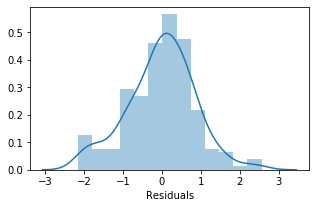

In [14]:
# Note: if we truncated the y_train, we could compare the predicted vs. the truncated values
# The extremes in this distribution do not come from the predicted, but from the actual values
# Remember: that we even clipped y_train values
# Once should explore such extreme movements with a different model
residuals = pd.Series((predicted - y_train).values, name="Residuals")
ax = sns.distplot(residuals)

In [15]:
def add_pred(name, pred):
    pred = inverters[y_feature](pred)
    
    meta['Restored:' + name] = (meta['MeanEndPrice'] * (pred + 1.0)).shift(1)

add_pred('y', y_train)
add_pred('y[t - 1]', y_train.shift(1)) 
add_pred('same_as_before', 0.0) 
add_pred('pred', predicted)

Notice that we don't predict the actual price, but percent return.
Having percent return and the previous price we can construct the next price.
This is what we show below. There are some discrepancies because we truncate the actual percent
returns to improve the stability of model fit.

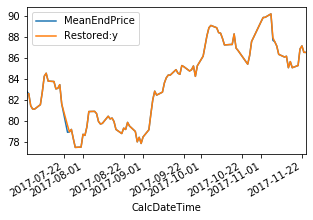

In [16]:
meta[['MeanEndPrice', 'Restored:y']].head(100).plot()

Next we plot our predictions (Restored:pred) and our baseline(Restored:y[t-1]).
Our baseline is simply the curve shifted, from the present, one step into the future.

As it can be observed the baseline is more noisy, so the model improved upon the simple baseline.

### Important: we predict percent return, but can transform it to predicted price

It is important to note that the model predict the change from the current timestep.
From the change of direction and magnitude, we can derive the next (predicted) price.
Predicted the same price (i.e. no change) is not useful, as it gives us no information.
However, predicting the same price, corresponds to just shifting the price curve, from the past
into the future. Such shifts are useful, and used in moving averages analysis to predict a change
in direction. Therefore, "predicting no-change" or just shifting the curves could be informative
if we try to predict change in direction.
However, here we predict the change.
One could notice, that if we are able to better predict the curve, than by just moving one step,
we could potentially do a bit better in moving average analysis.

Below, one could notice that the predicted curve derived from our model is still a better fit to the true
one than the moved curve. However, if we "average" both curves we could improve the model stability,
as we'll get a smoother curve.

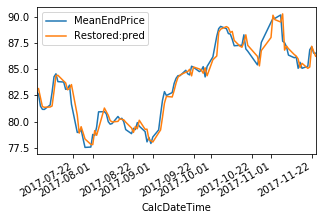

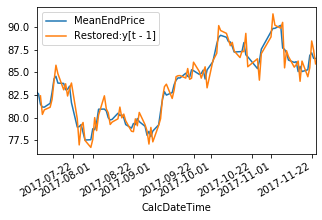

In [17]:
meta[['MeanEndPrice', 'Restored:pred']].head(100).plot()
meta[['MeanEndPrice', 'Restored:y[t - 1]']].head(100).plot()

Next we show the same three plots but over a smaller timescale, so one could better see the results of model fitting.

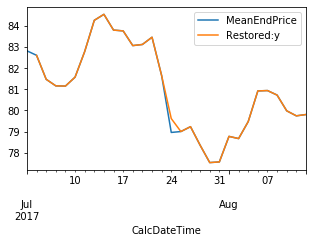

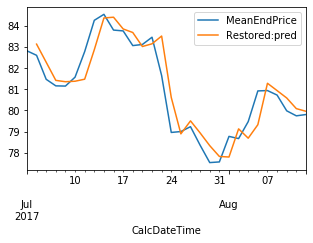

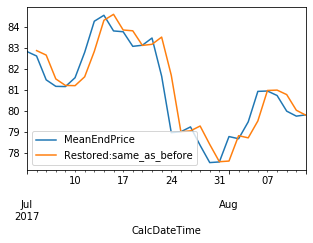

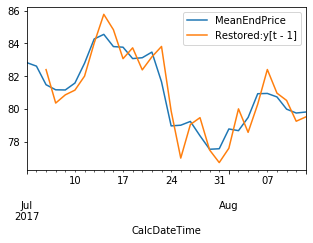

In [18]:
meta[['MeanEndPrice', 'Restored:y']].head(30).plot()
meta[['MeanEndPrice', 'Restored:pred']].head(30).plot()
meta[['MeanEndPrice', 'Restored:same_as_before']].head(30).plot()
meta[['MeanEndPrice', 'Restored:y[t - 1]']].head(30).plot()

### Correlations between prices
Below we show the correlations between prices. We introduce two simple baselines:
- `Restored:y[t - 1]`, obtain the price at `t` by predict the same percent return as the previous timestep
- Directly predict that the price at `t` is the same price as `(t - 1)`. This corresponds to percent return of 0

Notice that even with a few trival baselines we have very high correlations.

This is why one should try to predict percent return, not the actual price.

In [19]:
meta['MeanEndPrice[t - 1]'] = meta['MeanEndPrice'].shift(1)
meta[['MeanEndPrice', 'Restored:pred', 'Restored:y[t - 1]', 'MeanEndPrice[t - 1]']].corr()[['MeanEndPrice']]

,MeanEndPrice
MeanEndPrice,1.000000
Restored:pred,0.981327
Restored:y[t - 1],0.962052
MeanEndPrice[t - 1],0.976627


## Agreement with actual market move

In [20]:
def agreement(a, b):
    agree = np.where(np.sign(a)*np.sign(b) == 1.0, 1.0, 0.0).sum()
    n = a.shape[0]
    return 100.0*agree/n

model = agreement(meta['y'], meta['predicted'])
baseline = agreement(meta['y'], meta['y[t - 1]'])
print("""Model agrees with actual AVERAGE market movement in {} percent,
while baseline agrees with AVERAGE market movement in {} percent.
(Note: on the training set)
""".format(model, baseline))

Model agrees with actual AVERAGE market movement in 63.888888888888886 percent,
while baseline agrees with AVERAGE market movement in 51.388888888888886 percent.
(Note: on the training set)



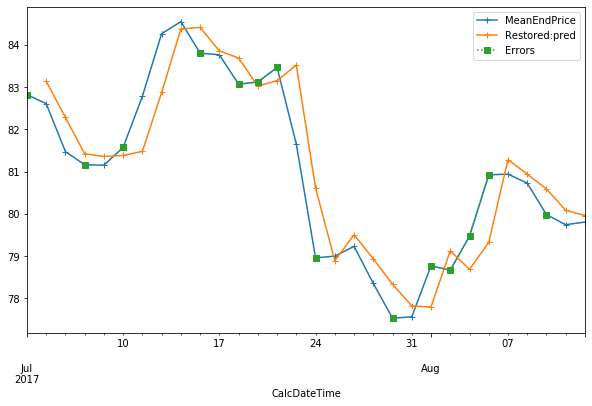

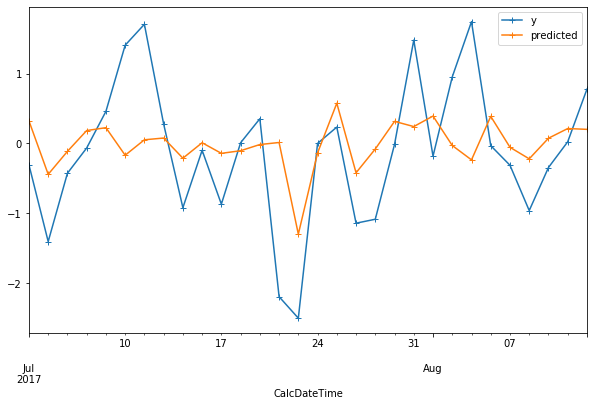

In [21]:
errors = np.sign(meta['y']) * np.sign(meta['predicted']) != 1.0 

meta['Errors'] = np.where(errors, meta['MeanEndPrice'], np.nan)

mpl.rcParams['figure.figsize'] = (10, 6)
meta[['MeanEndPrice', 'Restored:pred', 'Errors']].head(30).plot(style=['+-', '+-', 's:'])
meta[['y', 'predicted']].head(30).plot(style=['+-', '+-'])


### Analysis of disagreement between the baseline and the predictions.

We see that the errors happen when there is a change or trend. We can try to find other features which
predict the movement better in this situation. We did so by introducing the non-linear feature enabled upon a flag
`enable_non_linear_features`. Simply rerun the notebook with the flag enable.

## Idea 1
The idea is that when there are abrupt changes (i.e. the last two changes are with different signs), we
can look further into the future, i.e. try to predict with a longer time horizon to get a sense of the change.
We could use another predictive model, or we can introduce a feature that looks longer in the past.
The idea of this feature is that 1) such features are useful for longer term prediction, 2) statistically they are more stable.

## Idea 2
If two statistical models diagree that might be an early sign with a change of trend.
At this point this is only a speculative finding, but if we think of this baseline of simply following
the trend, a disgreement would mean that our predictive model finds extra information.
In this case, we could try to pull our model towards the more basic model when there is a disagreement.


## Idea 3

Below we'd like to see where the baseline model and our model disagree. Perhaps, we can use the disagreement to our advantage. Based on this analysis we introduce, more features under the flag, `enable_model_boosting`

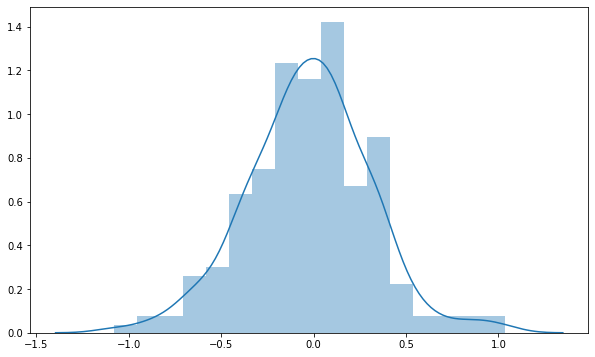

In [22]:
disagreement = ((meta['MeanEndPrice[t - 1]'] - meta['Restored:pred']) ).dropna()
ax = sns.distplot(disagreement)

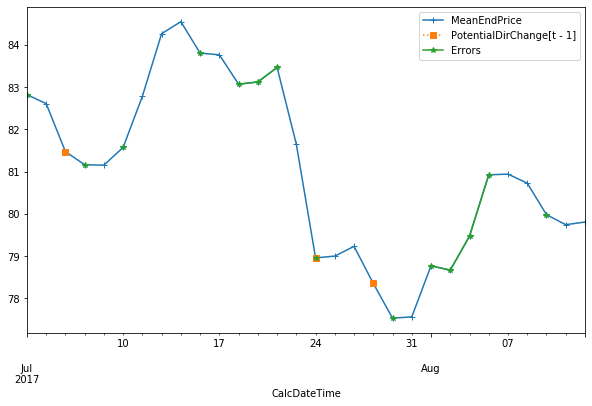

In [23]:
disagreement = np.absolute((meta['MeanEndPrice[t - 1]'] - meta['Restored:pred']) > 0.25)
        
meta['DisagreementForDirChange[t - 1]'] = disagreement

meta['PotentialDirChange[t - 1]'] = np.where(disagreement, meta['MeanEndPrice'], np.nan)

mpl.rcParams['figure.figsize'] = (10, 6)
meta[['MeanEndPrice', 'PotentialDirChange[t - 1]', 'Errors']].head(30).plot(style=['+-', 's:', '*-'])

## Correlation on the set of errors

Another way to look at the errors is to get a subset of the data where the errors appear and check for
correlation with our features.

On this set, however, the most strongly feature is `x:Da@1D` (need to set the `enable_non_linear_features_flag`).
We see that this non-linear feature is the most strongly correlated.
This means that to address problems around change of direction, we need to think longer term, i.e. to predict say
1 day ahead, we may benefit from predictions, 2, 3, etc. days ahead.

In [24]:
disagreement = (np.sign(meta['y']) * np.sign(meta['predicted'])) != 1.0 

single_stock[disagreement].corr().sort_values(k, ascending=False)[['y:AdjustedPctChange[t + 1]']]

,y:AdjustedPctChange[t + 1]
y:AdjustedPctChange[t + 1],1.000000
x:RevPctChange@1D,-0.083834
x:RevPctChange@12H,-0.083834
x:Direction@1D,-0.309228
x:Direction@12H,-0.311074
x:AdjustedPctChange@12H,-0.327226
x:EndToMean@12H,-0.327441
x:EndToMean@1D,-0.368809
x:AdjustedPctChange@1D,-0.368809
x:H1@12H,-0.380460


When our model disagrees with the baseline, we have a stronger negative correlation with the non-linear feature `Da` than before. This means that it might be beneficial to look where the models disagree, and predict in the opposite direction of `Da`

In [25]:
disagreement = (np.sign(meta['y[t - 1]']) * np.sign(meta['predicted'])) != 1.0 

single_stock[disagreement].corr().sort_values(k, ascending=False)[['y:AdjustedPctChange[t + 1]']]

,y:AdjustedPctChange[t + 1]
y:AdjustedPctChange[t + 1],1.000000
x:EndToMean@1D,0.395145
x:AdjustedPctChange@1D,0.395145
x:H1@1D,0.352705
x:Direction@12H,0.322461
x:EndToMean@12H,0.311633
x:AdjustedPctChange@12H,0.311493
x:H1@12H,0.290577
x:Direction@1D,0.109767
x:RevPctChange@1D,-0.137893


## Observed Challenges

### Data alignment
The challenges here lie with aligning the data. Shifting operations, forward filling, dealing with nans are potentially error prone. One needs to put a lot of effort into testing those edge cases. For example, there are many minutes and days without trades. We are preparing another supporting notebook for this.

From financial perspective, beginnings, ends of days and Monday, and Fridays should be treated differently.
Another challenge is creating features at different frequencies as one needs to be aware of trading hours.

### Evaluation or error measurment

Here we have taken a simple strategy to measure correlations and agreement in the prediction of the directions.

### Error analysis

When the model makes errors, does that signal a change of trend or is simply noise.
We could analyze the cases with errors and look for extra features.
ROC curves would be helpful, as well as running the model predictions with different strategies

### Feature Selection

A lot of our features are correlated. This is normal since they derive from 3 underlying signals: EndPrice, MinPrice, MaxPrice

In general this does mean we should drop them and keep the most important onces, although we could.
For example, in image recognition a lot of raw features (image pixels) are "locally correlated", but people
have found a way to make most of those correlations

### Non-linear models

Instead of relying on putting non-linearity in our features we can consider non-linear models such as decision trees and neural nets.

A lot of practitioners in the stock market technical analysis rely on heuristics that are non-linear in nature
to spot a change of trend. For example, crossing points between lines connecting last local minimums and maximums,
or counting a number of consequtive down and up movements.

### Models at different resolutions

Our findings here, as well as the practice of stock market analysts, point to looking at data at different scales.

### Abstraction

Once we are done with data exploration, it is clear that one needs solid software engineering to create a proper data transformation pipeline. We want our feature generation, data alignment, model fitting and model predictions to be first class citizens.
If we are able to abstract the model, we could run it over multiple intervals, say 1 day, 2 days and so on,
and build more complex models on top.

In [26]:
!echo "Last run on `date`"

Last run on Wed Jan 22 18:36:03 UTC 2020
